[![在 Colab 中打开](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![在 LangChain Academy 中打开](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)


# 状态 Reducer

## 回顾

我们已经介绍了定义 LangGraph 状态 schema 的几种方式，包括 `TypedDict`、`Pydantic` 和 `Dataclasses`。

## 目标

接下来深入了解 reducer，它用于指定在状态 schema 中特定键 / 通道的更新方式。


In [1]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## 默认的覆盖式状态

我们先用一个 `TypedDict` 作为状态 schema。


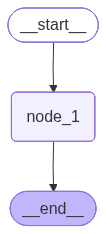

In [ ]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    foo: int


def node_1(state):
    print("---Node 1---")
    return {"foo": state["foo"] + 1}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png(max_retries=5, retry_delay=2.0)))

In [8]:
graph.invoke({"foo": 1})

---Node 1---


{'foo': 2}

看一下状态更新 `return {"foo": state['foo'] + 1}`。

如前所述，LangGraph 默认并不知道你希望怎样更新状态。

因此它会在 `node_1` 中直接覆盖 `foo` 的值：

```
return {"foo": state['foo'] + 1}
```

如果我们传入 `{'foo': 1}` 作为输入，图返回的状态就是 `{'foo': 2}`。

## 分支

再来看一个节点分支的情况。


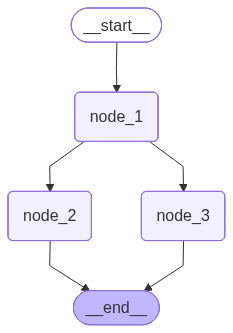

In [9]:
class State(TypedDict):
    foo: int


def node_1(state):
    print("---Node 1---")
    return {"foo": state["foo"] + 1}


def node_2(state):
    print("---Node 2---")
    return {"foo": state["foo"] + 1}


def node_3(state):
    print("---Node 3---")
    return {"foo": state["foo"] + 1}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
from langgraph.errors import InvalidUpdateError

try:
    graph.invoke({"foo": 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")

---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


我们发现一个问题！

节点 1 同时指向节点 2 和节点 3。

节点 2 和节点 3 并行运行，也就是说它们位于图的同一步骤中。

它们都会在*同一步骤*尝试覆盖状态。

这让图无法判定应该保留哪个结果！


## Reducer

[Reducer](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) 为我们提供了通用的解决方案。

它们用于指定如何执行状态更新。

我们可以用 `Annotated` 类型来指定一个 reducer 函数。

例如，这里我们希望把每个节点返回的值追加起来，而不是互相覆盖。

只需一个能够执行此操作的 reducer：Python 内置 `operator` 模块中的 `operator.add`。

当 `operator.add` 应用于列表时，它会执行列表拼接。


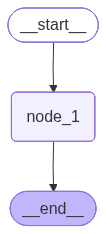

In [11]:
from operator import add
from typing import Annotated


class State(TypedDict):
    foo: Annotated[list[int], add]


def node_1(state):
    print("---Node 1---")
    return {"foo": [state["foo"][0] + 1]}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [12]:
graph.invoke({"foo": [1]})

---Node 1---


{'foo': [1, 2]}

现在状态中的 `foo` 键是一个列表。

这个 `operator.add` reducer 会把每个节点的更新追加到该列表中。


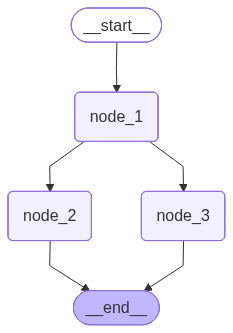

In [13]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state["foo"][-1] + 1]}


def node_2(state):
    print("---Node 2---")
    return {"foo": [state["foo"][-1] + 1]}


def node_3(state):
    print("---Node 3---")
    return {"foo": [state["foo"][-1] + 1]}


# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

可以看到，节点 2 和节点 3 的更新是在同一步骤并发执行的。


In [14]:
graph.invoke({"foo": [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

现在试着让 `foo` 为 `None`。

可以看到会出错，因为我们的 reducer `operator.add` 会尝试把 `NoneType` 与 `node_1` 中的列表拼接。


In [15]:
try:
    graph.invoke({"foo": None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## 自定义 Reducer

对于这种情况，我们也可以[编写自定义 reducer](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state)。

例如，我们可以定义一段逻辑来合并列表，并在其中任意一方为 `None` 时进行处理。


In [16]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right


class DefaultState(TypedDict):
    foo: Annotated[list[int], add]


class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

在 `node_1` 中，我们会追加数值 2。


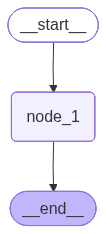

TypeError occurred: can only concatenate list (not "NoneType") to list


In [17]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}


# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo": None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

现在使用自定义 reducer，可以看到不再抛出错误。


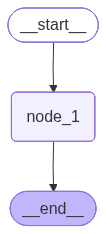

---Node 1---
{'foo': [2]}


In [18]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo": None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## 消息

在第一模块里，我们展示了如何使用内置的 `add_messages` reducer 来处理状态中的消息。

我们还提到，[如果想处理消息，`MessagesState` 非常便利](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)。

* `MessagesState` 内置了一个 `messages` 键
* 它还为该键内置了 `add_messages` reducer

这两种写法是等价的。

为了简洁，我们将通过 `from langgraph.graph import MessagesState` 来使用 `MessagesState` 类。


In [19]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages


# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc


# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    added_key_1: str
    added_key_2: str
    # etc

接下来聊聊 `add_messages` reducer 的一些用法。


In [20]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model"),
    HumanMessage(
        content="I'm looking for information on marine biology.", name="Lance"
    ),
]

# New message to add
new_message = AIMessage(
    content="Sure, I can help with that. What specifically are you interested in?",
    name="Model",
)

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='4a0717df-430f-4cfe-a7bc-a7b0fcab0afe'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='5a77accd-369f-4daf-a47d-428464ff266c'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='e8b35e46-63a4-446d-a295-281e3efab41a')]

因此可以看到，`add_messages` 会把消息追加到状态中的 `messages` 键。

### 重写

展示几个配合 `add_messages` reducer 的实用技巧。

如果我们传入的消息 ID 与列表中已有的相同，它会被覆盖！


In [21]:
# Initial state
initial_messages = [
    AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
    HumanMessage(
        content="I'm looking for information on marine biology.", name="Lance", id="2"
    ),
]

# New message to add
new_message = HumanMessage(
    content="I'm looking for information on whales, specifically", name="Lance", id="2"
)

# Test
add_messages(initial_messages, new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", additional_kwargs={}, response_metadata={}, name='Lance', id='2')]

### 删除

`add_messages` 也[支持删除消息](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/)。

只需使用 `langchain_core` 中的 [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) 即可。


In [22]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(
    AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3")
)
messages.append(
    HumanMessage(
        "Yes, I know about whales. But what others should I learn about?",
        name="Lance",
        id="4",
    )
)

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2')]


In [23]:
add_messages(messages, delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4')]

可以看到，`delete_messages` 中指定的消息 ID 1 和 2 被 reducer 移除了。

稍后我们会看到更完整的示例。
